In [30]:
import numpy as np
import pathlib
import sys
sys.path.append('../../src/')
import graphtools
from plotly3d.plot import scatter
import scprep
import matplotlib.pyplot as plt
import phate


In [168]:
def get_alpha_decay_graph(
    X,
    knn: int = 5,
    decay: float = 40.0,
    anisotropy: float = 0,
    n_pca: int = None,
    **kwargs
):
    return graphtools.Graph(
        X,
        knn=knn,
        decay=decay,
        anisotropy=anisotropy,
        n_pca=n_pca,
        use_pygsp=True,
        random_state=42,
    ).to_pygsp()

class DiffusionMap():
    def __init__(self, n_components=2, t=3, **kwargs) -> None:
        self.n_components = n_components
        self.kwargs = kwargs
        self.t = t
    def fit(self, data):
        G = get_alpha_decay_graph(data, **self.kwargs)
        Dinvhf = np.diag(1 / np.sqrt(G.K.toarray().sum(axis=1)))
        self.Dinvhf = Dinvhf
        A = Dinvhf @ G.K @ Dinvhf
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        eigenvalues = eigenvalues[::-1]
        eigenvectors = eigenvectors[:, ::-1]
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.emb_dm = Dinvhf @ eigenvectors[:, :self.n_components] * eigenvalues[:self.n_components] ** self.t
        return self
    def transform(self, data):
        return self.emb_dm
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [103]:
data0 = np.load('../../data/eb_subset_all.npz')
# data0 = np.load('../../data/hemisphere_hi_dim2.npz')
data_dict = {f: data0[f] for f in data0.files}

In [104]:
G = get_alpha_decay_graph(data_dict['data'])
Dinvhf = np.diag(1 / np.sqrt(G.K.toarray().sum(axis=1)))
A = Dinvhf @ G.K @ Dinvhf
eigenvalues, eigenvectors = np.linalg.eigh(A)
eigenvalues_reordered = eigenvalues[::-1]
eigenvectors_reordered = eigenvectors[:, ::-1]
emb_dm = Dinvhf @ eigenvectors_reordered[:, :3] * eigenvalues_reordered[:3]

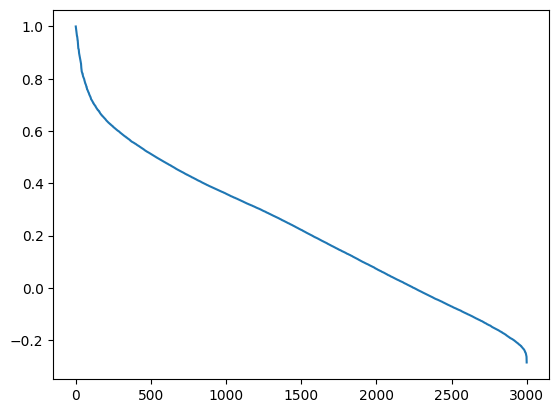

In [122]:
plt.plot(eigenvalues_reordered)

In [131]:
fig = scatter(emb_dm, data_dict['colors'], rescale=True)
fig.show()

In [132]:
white_noise = np.random.randn(*data_dict['data'].shape) * data_dict['data'].std()

In [134]:
data_filter = Dinvhf @ eigenvectors_reordered * eigenvalues_reordered ** 3
noise_filter = Dinvhf @ eigenvectors_reordered * (1 - eigenvalues_reordered ** 3)

In [153]:
data_noise = data_filter @ white_noise
noise_noise = noise_filter @ white_noise

In [154]:
noise_noise = noise_noise - noise_noise.mean(axis=0) + data_dict['data'].mean(axis=0)
noise_noise = noise_noise / noise_noise.std(axis=0) * data_dict['data'].std(axis=0) * 0.1

In [155]:
dmd = DiffusionMap(n_components=3, t=3)
emb_data = dmd.fit_transform(data_noise)
dmn = DiffusionMap(n_components=3, t=3)
emb_noise = dmn.fit_transform(noise_noise)

In [156]:
fig = scatter(emb_data, data_dict['colors'], rescale=True)
fig.show()

In [157]:
fig = scatter(emb_noise, data_dict['colors'], rescale=True)
fig.show()

In [164]:
from negative_sampling import add_negative_samples, make_hi_freq_noise

In [169]:
dm2 = DiffusionMap(n_components=3, t=3, random_state=12).fit(data_dict['data'])

In [173]:
noise_noise2 = make_hi_freq_noise(data_dict['data'], dm2, noise_rate=0.1)

In [174]:
noise_noise2

array([[ 0.07449202, -0.09762933, -0.09548348, ...,  0.13582677,
         0.06769544, -0.10973069],
       [-0.16980044,  0.34775981,  0.27834847, ...,  0.02454995,
         0.04345744,  0.0255302 ],
       [-0.43817345, -0.34048731, -0.26420063, ..., -0.1749368 ,
         0.05716003, -0.10290265],
       ...,
       [ 0.07594695, -0.05449255,  0.22420965, ...,  0.11206177,
         0.16928094, -0.06661689],
       [-0.48277339, -0.28634527,  0.11753466, ..., -0.0089473 ,
        -0.07750718,  0.08574043],
       [ 0.25591574, -0.1935521 ,  0.01425279, ..., -0.07512223,
         0.06450745, -0.01995352]])

In [175]:
dmn2 = DiffusionMap(n_components=3, t=3)
emb_noise2 = dmn2.fit_transform(noise_noise2)

In [176]:
fig = scatter(emb_noise2, data_dict['colors'], rescale=True)
fig.show()

In [178]:
phate_op = phate.PHATE(n_components=3, random_state=42)
emb_phate = phate_op.fit_transform(data_dict['data'])
emb_phate_noise = phate_op.fit_transform(noise_noise2)
emb_phate_all = phate_op.fit_transform(np.concatenate([data_dict['data'], noise_noise2], axis=0))

Calculating PHATE...
  Running PHATE on 3000 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.48 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.51 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.46 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.67 seconds.
  Calculated landmark operator in 5.01 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 3.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.08 seconds.
  Calculating metric MDS...


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



  Calculated metric MDS in 123.89 seconds.
Calculated PHATE in 133.54 seconds.
Calculating PHATE...
  Running PHATE on 3000 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.54 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.96 seconds.
  Calculated landmark operator in 4.80 seconds.
  Calculating optimal t...
    Automatically selected t = 8
  Calculated optimal t in 3.40 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.54 seconds.
  Calculating metric MDS...


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



  Calculated metric MDS in 32.32 seconds.
Calculated PHATE in 41.62 seconds.
Calculating PHATE...
  Running PHATE on 6000 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 2.00 seconds.
    Calculating affinities...
    Calculated affinities in 1.28 seconds.
  Calculated graph and diffusion operator in 3.34 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.55 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.87 seconds.
  Calculated landmark operator in 7.61 seconds.
  Calculating optimal t...
    Automatically selected t = 32
  Calculated optimal t in 4.38 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.06 seconds.
  Calculating metric MDS...


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



  Calculated metric MDS in 44.66 seconds.
Calculated PHATE in 61.07 seconds.


In [180]:
emb_phate_all2 = phate_op.fit_transform(np.concatenate([data_dict['data'], data_dict['data']+noise_noise2], axis=0)*10)

Calculating PHATE...
  Running PHATE on 60000 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...


In [179]:
scatter(emb_phate, data_dict['colors'], rescale=True).show()
scatter(emb_phate_noise, data_dict['colors'], rescale=True).show()
scatter(emb_phate_all, np.concatenate([np.ones(data_dict['data'].shape[0]), np.zeros(data_dict['data'].shape[0])], axis=0), rescale=True).show()

In [ ]:
scatter(emb_phate_all2, np.concatenate([np.ones(data_dict['data'].shape[0]), np.zeros(data_dict['data'].shape[0])], axis=0), rescale=True).show()

In [161]:
data_new = np.r_[data_dict['data'], noise_noise]

In [162]:
dmnew = DiffusionMap(n_components=3, t=3)
emb_new = dmnew.fit_transform(data_new)

In [163]:
scatter(emb_new, np.r_[np.zeros(data_dict['data'].shape[0]), np.ones(noise_noise.shape[0])], rescale=True).show()

In [118]:
data0 = np.load('../../data/eb_subset_all.npz')
data_dict = {f: data0[f] for f in data0.files}
data_dict = add_negative_samples(data_dict, subset_rate=0.5, noise_rate=0.2, seed=42)
pathlib.Path('../../data/negative_sampling/').mkdir(parents=True, exist_ok=True)
np.savez('../../data/negative_sampling/eb_subset_all.npz', **data_dict)

NameError: name 'add_negative_samples' is not defined

In [ ]:
data0 = np.load('../../toy_data/converted/make_mix_surface.npz')
data_dict = {f: data0[f] for f in data0.files}
data_dict = add_negative_samples(data_dict, subset_rate=0.5, noise_rate=0.2, seed=42)
pathlib.Path('../../data/negative_sampling/').mkdir(parents=True, exist_ok=True)
np.savez('../../data/negative_sampling/make_mix_surface.npz', **data_dict)

In [ ]:
data0 = np.load('../../data/hemisphere_hi_dim2.npz')
data_dict = {f: data0[f] for f in data0.files}
data_dict = add_negative_samples(data_dict, subset_rate=0.5, noise_rate=0.2, seed=42)
pathlib.Path('../../data/negative_sampling/').mkdir(parents=True, exist_ok=True)
np.savez('../../data/negative_sampling/hemisphere_hi_dim2.npz', **data_dict)

In [ ]:
data0 = np.load('../../data/hemisphere.npz')
data_dict = {f: data0[f] for f in data0.files}
data_dict = add_negative_samples(data_dict, subset_rate=0.5, noise_rate=0.2, seed=42)
pathlib.Path('../../data/negative_sampling/').mkdir(parents=True, exist_ok=True)
np.savez('../../data/negative_sampling/hemisphere.npz', **data_dict)